In [1]:
import xenonpy
import pickle
from rdkit.Chem import AllChem
from plotools import *
%run ../samples/tools.ipynb
np.random.seed(202309)

In [2]:
data = pd.read_csv('../../data/PI1M_predicted.csv')
data_collect = pd.read_csv('../../data/poly_dataset_imputation.csv')
data_part = data.loc[:, ['SMILES', 'He', 'H2', 'N2', 'O2', 'CO2', 'CH4']]
data_collect_part = data_collect.loc[:, ['SMILES', 'log10_He_Bayes', 'log10_H2_Bayes', 'log10_N2_Bayes', 'log10_O2_Bayes', 'log10_CO2_Bayes', 'log10_CH4_Bayes']]
data_collect_part = data_collect_part.rename(columns={'log10_He_Bayes': 'He', 'log10_H2_Bayes': 'H2', 'log10_N2_Bayes': 'N2', 'log10_O2_Bayes': 'O2', 'log10_CO2_Bayes': 'CO2', 'log10_CH4_Bayes': 'CH4'})
train_data = pd.concat([data_part, data_collect_part], axis=0)


In [3]:
train_data = data_collect_part.copy()

<module 'matplotlib.pyplot' from '/home/naoren/anaconda3/envs/cpoly/lib/python3.9/site-packages/matplotlib/pyplot.py'>

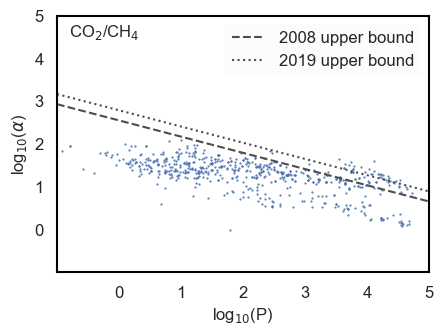

In [4]:
draw_properties(train_data, 'CO2', 'CH4')

In [5]:
from xenonpy.descriptor import fingerprint

fp_class = fingerprint.ECFP(radius=2, input_type='smiles')
fp = fp_class.transform(train_data['SMILES'], return_type='df')

In [6]:
with open('../models/GPR.pkl', 'rb') as f:
    gpr_model = pickle.load(f)

In [7]:
train_data

,SMILES,He,H2,N2,O2,CO2,CH4,alpha_CO2_CH4,k_CO2_CH4
0,*c1ccc(N2C(=O)c3ccc(C(c4ccc5c(c4)C(=O)N(*)C5=O...,1.908360,1.890980,0.176091,0.907411,1.591065,-0.148742,1.739806,2.343456
1,*c1ccc(N2C(=O)c3ccc(C(c4ccc5c(c4)C(=O)N(*)C5=O...,2.038954,2.029384,0.409933,1.103804,1.792392,0.117271,1.675120,2.355154
2,*c1ccc(N2C(=O)c3ccc(C(c4ccc5c(c4)C(=O)N(*)C5=O...,2.193566,2.195900,0.651278,1.328380,2.060698,0.399674,1.661024,2.442853
3,*c1cccc(N2C(=O)c3ccc(C(c4ccc5c(c4)C(=O)N(*)C5=...,1.667569,1.531479,-0.468521,0.342423,0.924279,-0.886057,1.810336,2.161008
4,*c1cccc(N2C(=O)c3ccc(C(c4ccc5c(c4)C(=O)N(*)C5=...,1.757188,1.673021,-0.267606,0.544068,1.123852,-0.677781,1.801632,2.228022
...,...,...,...,...,...,...,...,...,...
605,*CC(*)OC(=O)c1ccc(C)cc1,1.164353,1.098777,-0.469800,0.235528,0.828015,-0.379864,1.207879,1.522028
606,*CC(*)OC(=O)c1ccccc1C,0.848805,0.911010,-1.066007,-0.327902,0.348305,-0.939302,1.287607,1.419754
607,*CC(*)OC(=O)c1cccc(C)c1,0.915400,0.885753,-1.057992,-0.304518,0.328380,-0.928118,1.256498,1.381085
608,*CC(*)OC(=O)c1ccccc1,1.029384,0.700278,-0.713510,-0.437361,0.800717,-1.280573,2.081290,2.385082


In [7]:
%%time
from xenonpy.inverse.iqspr import GaussianLogLikelihood
prop = ['CO2','CH4','k_CO2_CH4']
target_range = {'CO2':(-6,6), 'CH4':(-6,6), 'k_CO2_CH4': (2.7898, np.inf)}

custom_model = {'CO2':gpr_model, 'CH4':gpr_model, 'k_CO2_CH4':gpr_model}
prd_mdls = GaussianLogLikelihood(descriptor=fp_class, targets = target_range, **custom_model)
prd_mdls.update_targets(reset=True,**target_range)

CPU times: user 32.5 ms, sys: 10.8 ms, total: 43.3 ms
Wall time: 41.7 ms


In [8]:
output2 = prd_mdls.predict(train_data['SMILES'])

/home/naoren/anaconda3/envs/cpoly/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(
/home/naoren/anaconda3/envs/cpoly/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(


In [9]:
output2

,CO2: mean,CO2: std,CH4: mean,CH4: std,k_CO2_CH4: mean,k_CO2_CH4: std
0,1.609278,0.459993,-0.083002,0.554954,2.302840,0.842961
1,1.609278,0.459993,-0.083002,0.554954,2.302840,0.842961
2,1.609278,0.459993,-0.083002,0.554954,2.302840,0.842961
3,1.195824,0.474430,-0.563906,0.572370,2.213425,0.869416
4,1.195824,0.474430,-0.563906,0.572370,2.213425,0.869416
...,...,...,...,...,...,...
605,0.785732,0.544270,-0.416947,0.656628,1.500785,0.997401
606,0.593220,0.560849,-0.679739,0.676629,1.498027,1.027783
607,0.513938,0.555583,-0.747942,0.670277,1.456868,1.018134
608,0.711944,0.598068,-0.519100,0.721533,1.501155,1.095990


In [11]:
%%time
tmp_ll = prd_mdls(train_data['SMILES'], **target_range)
tmp_ll

/home/naoren/anaconda3/envs/cpoly/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(
/home/naoren/anaconda3/envs/cpoly/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(


CPU times: user 1.74 s, sys: 1.66 s, total: 3.4 s
Wall time: 6.24 s


,CO2,CH4,k_CO2_CH4
0,-6.793200e-22,-2.933096e-28,-1.266769
1,-6.793200e-22,-2.933096e-28,-1.266769
2,-6.793200e-22,-2.933096e-28,-1.266769
3,-2.113458e-24,-9.557237e-31,-1.371671
4,-2.113458e-24,-9.557237e-31,-1.371671
...,...,...,...
605,-4.838187e-22,-7.382264e-23,-2.321625
606,-2.700050e-22,-1.887379e-15,-2.259494
607,-2.687129e-23,-2.331468e-15,-2.351410
608,-4.705605e-19,-1.521014e-14,-2.121589


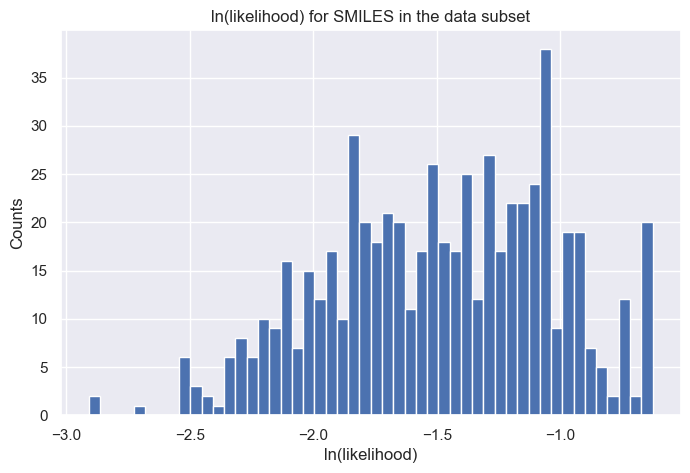

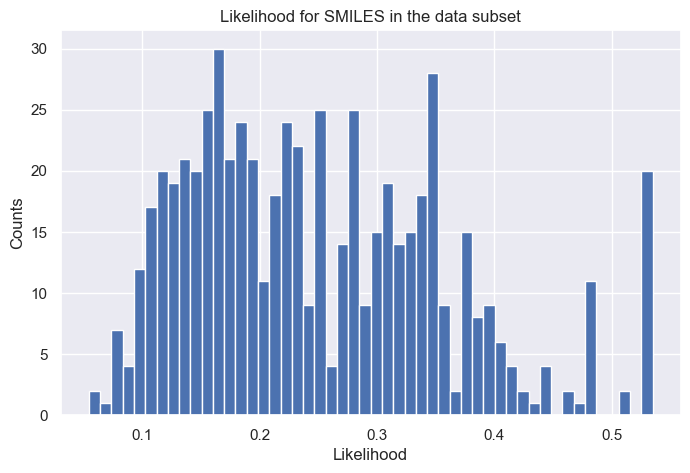

In [12]:
tmp = tmp_ll.sum(axis = 1, skipna = True)

_ = plt.figure(figsize=(8,5))
_ = plt.hist(tmp, bins=50)
_ = plt.title('ln(likelihood) for SMILES in the data subset')
_ = plt.xlabel('ln(likelihood)')
_ = plt.ylabel('Counts')
_ = plt.show()

# plot histogram of likelihood values
_ = plt.figure(figsize=(8,5))
_ = plt.hist(np.exp(tmp), bins=50)
_ = plt.title('Likelihood for SMILES in the data subset')
_ = plt.xlabel('Likelihood')
_ = plt.ylabel('Counts')
_ = plt.show()

In [14]:
%%time

from xenonpy.inverse.iqspr import NGram

n_gram = NGram()

n_gram.fit(train_data['SMILES'],train_order=6)

/home/naoren/anaconda3/envs/cpoly/lib/python3.9/site-packages/xenonpy/inverse/iqspr/modifier.py:166: RuntimeWarning: max <sample_order>: 10 is greater than max <train_order>: 6,max <sample_order> will be reduced to max <train_order>
  warnings.warn(
100%|██████████| 610/610 [00:45<00:00, 13.48it/s]


CPU times: user 44 s, sys: 1.71 s, total: 45.7 s
Wall time: 45.3 s


NGram(ngram_table=[[[             c    &    !    O    C    (  =O   N   /  =C  [Si]  *  n  -c  F  \
['*']      260    0   10  179   48    0   0  41  76   5     0  0  0   0  0   
['c']        0  553    0    0    0    0   0   0   0   0     0  0  0   0  0   
[0]          0   12  438   58   61    8   4   0   0   0     2  0  0   2  0   
['O']      184    0   46    0   27    0   0   0   0   0     0  9  0   0  0   
['C']        1    8  100    5  112  162   0  13   0   4     1  1  0   0  0   
[')']       79    0    0   24   73   49   1   2   0  19     9  0  1   0  5   
['=O']       0    0    5    0    0    0   0   0   0   0     0  0  0   0  0   
['N']       28   15    0    0    2    0   0   0   0   0     0  0  0   0  0   
['/']        0    0    0    0   79    0   0   0   0   0     0  0  0   0  0   
['=C']       0    0    0    0    5   20   0   0   3   0     0  0  0   0  0   
['[Si]']     0    0    0    0    0   12   0   0   0   0     0  0  0   0  0   
['n']        0    1    0    0    0    0   0   0   0   0     0  0  0   0  0   
['-c']       0    2    0    0    0    0   0   0   0   0     0  0  0   0  0   
['F']        0    0...
['(', 'c', '&', 'c', 'c', 'c']  0  5  0
['(', '*', ')', 'o', 'c', 0]    5  0  0
['*', ')', 'o', 'c', 0, 'c']    0  0  5,
                                                     n  c  (  *  )  o  0
['c', '&', 'c', 'c', 'c', '&']  5  0  0  0  0  0  0
['&', 'c', 'c', 'c', '&', 'n']  0  5  0  0  0  0  0
['c', 'c', 'c', '&', 'n', 'c']  0  0  5  0  0  0  0
['c', 'c', '&', 'n', 'c', '(']  0  0  0  5  0  0  0
['c', '&', 'n', 'c', '(', '*']  0  0  0  0  5  0  0
['&', 'n', 'c', '(', '*', ')']  0  0  0  0  0  5  0
['n', 'c', '(', '*', ')', 'o']  0  5  0  0  0  0  0
['c', '(', '*', ')', 'o', 'c']  0  0  0  0  0  0  5]]],
      sample_order=(1, 6))

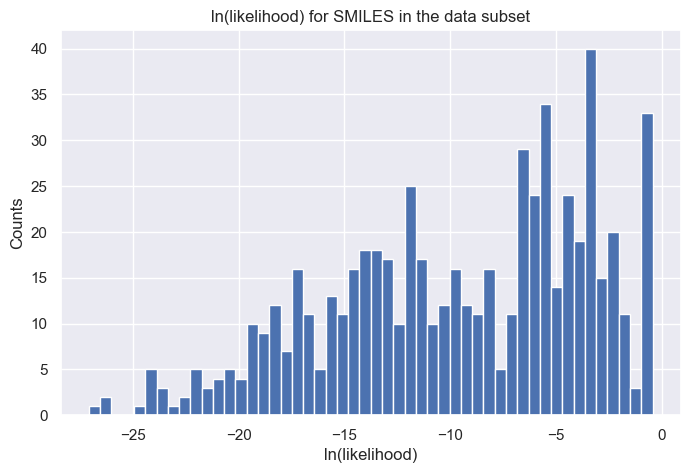

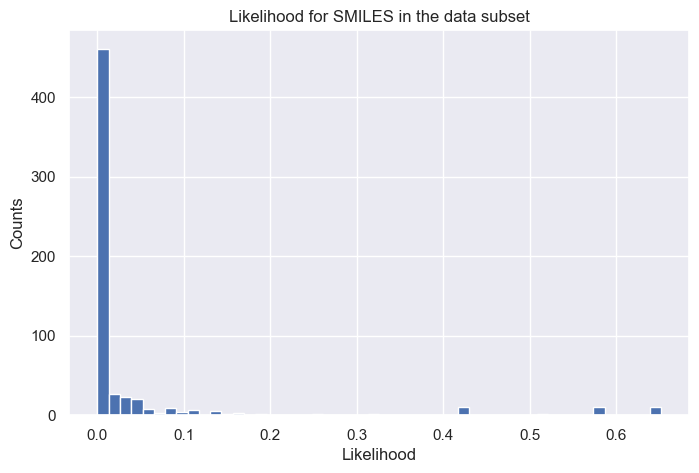

In [14]:
# tmp = tmp_ll.sum(axis = 1, skipna = True)

# _ = plt.figure(figsize=(8,5))
# _ = plt.hist(tmp, bins=50)
# _ = plt.title('ln(likelihood) for SMILES in the data subset')
# _ = plt.xlabel('ln(likelihood)')
# _ = plt.ylabel('Counts')
# _ = plt.show()

# # plot histogram of likelihood values
# _ = plt.figure(figsize=(8,5))
# _ = plt.hist(np.exp(tmp), bins=50)
# _ = plt.title('Likelihood for SMILES in the data subset')
# _ = plt.xlabel('Likelihood')
# _ = plt.ylabel('Counts')
# _ = plt.show()

In [17]:
# %%time
# from xenonpy.inverse.iqspr import NGram
# n_gram = NGram()
# n_gram.fit(train_data['SMILES'],train_order=6)

/home/naoren/anaconda3/envs/cpoly/lib/python3.9/site-packages/xenonpy/inverse/iqspr/modifier.py:166: RuntimeWarning: max <sample_order>: 10 is greater than max <train_order>: 6,max <sample_order> will be reduced to max <train_order>
  warnings.warn(
100%|██████████| 610/610 [00:47<00:00, 12.82it/s]


CPU times: user 46.5 s, sys: 1.33 s, total: 47.8 s
Wall time: 47.6 s


NGram(ngram_table=[[[             c    &    !    O    C    (  =O   N   /  =C  [Si]  *  n  -c  F  \
['*']      260    0   10  179   48    0   0  41  76   5     0  0  0   0  0   
['c']        0  553    0    0    0    0   0   0   0   0     0  0  0   0  0   
[0]          0   12  438   58   61    8   4   0   0   0     2  0  0   2  0   
['O']      184    0   46    0   27    0   0   0   0   0     0  9  0   0  0   
['C']        1    8  100    5  112  162   0  13   0   4     1  1  0   0  0   
[')']       79    0    0   24   73   49   1   2   0  19     9  0  1   0  5   
['=O']       0    0    5    0    0    0   0   0   0   0     0  0  0   0  0   
['N']       28   15    0    0    2    0   0   0   0   0     0  0  0   0  0   
['/']        0    0    0    0   79    0   0   0   0   0     0  0  0   0  0   
['=C']       0    0    0    0    5   20   0   0   3   0     0  0  0   0  0   
['[Si]']     0    0    0    0    0   12   0   0   0   0     0  0  0   0  0   
['n']        0    1    0    0    0    0   0   0   0   0     0  0  0   0  0   
['-c']       0    2    0    0    0    0   0   0   0   0     0  0  0   0  0   
['F']        0    0...
['(', 'c', '&', 'c', 'c', 'c']  0  5  0
['(', '*', ')', 'o', 'c', 0]    5  0  0
['*', ')', 'o', 'c', 0, 'c']    0  0  5,
                                                     n  c  (  *  )  o  0
['c', '&', 'c', 'c', 'c', '&']  5  0  0  0  0  0  0
['&', 'c', 'c', 'c', '&', 'n']  0  5  0  0  0  0  0
['c', 'c', 'c', '&', 'n', 'c']  0  0  5  0  0  0  0
['c', 'c', '&', 'n', 'c', '(']  0  0  0  5  0  0  0
['c', '&', 'n', 'c', '(', '*']  0  0  0  0  5  0  0
['&', 'n', 'c', '(', '*', ')']  0  0  0  0  0  5  0
['n', 'c', '(', '*', ')', 'o']  0  5  0  0  0  0  0
['c', '(', '*', ')', 'o', 'c']  0  0  0  0  0  0  5]]],
      sample_order=(1, 6))

In [3]:
# from xenonpy.descriptor import fingerprint

# fp3_ts = fingerprint.ECFP(radius=2, input_type='smiles')

# test_df = data_collect.copy()
# test_df['fp3'] = test_df.SMILES.apply(lambda x: fp3_ts.featurize(x))
# fp3 = np.array(test_df['fp3'].tolist())
# fp3 = fp3_ts.transform(test_df['SMILES'])


In [ ]:
# %%time
# from xenonpy.inverse.iqspr import GaussianLogLikelihood
# prop = ['CO2','CH4','k_CO2_CH4']
# target_range = {'CO2':(-6,6), 'CH4':(-6,6), 'k_CO2_CH4': (2.7898, np.inf)}

# prd_mdls = GaussianLogLikelihood(descriptor=fp_class, targets = target_range)
# prd_mdls.fit(train_data['SMILES'], train_data[prop])
# prd_mdls.update_targets(reset=True,**target_range)

CPU times: user 6.38 s, sys: 6.72 s, total: 13.1 s
Wall time: 1.23 s
